In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
import skimage.color as color
import pandas as pd

In [2]:
data = pd.read_csv('../input/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = '../input/grid_sizes.csv'
wkt_fname = '../input/train_wkt_v4.csv'
image_fname = '../input/three_band/'

In [3]:
def pan_esri(m, p):
    
    # original M band shapes
    m_shape_0 = m.shape[0]
    m_shape_1 = m.shape[1]
    
    m_scaled = np.empty((p.shape[0], p.shape[1], m.shape[2]-1))
        
    for i in range(m.shape[2]-1):
        m_scaled[:,:,i] = resize(m[:,:,i], (p.shape[0], p.shape[1]), preserve_range=True)
    
    ADJ = pan-m_scaled.mean(axis=2)
    m_scaled[:,:,:-1] = m_scaled[:,:,:-1] + ADJ[:,:, np.newaxis]
    
    for i in range(m.shape[2]-1):
        m[:,:,i] = resize(m_scaled[:,:,i], (m_shape_0, m_shape_1), preserve_range=True)
    
    return m

def stretch(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)

In [ ]:
# 0-coastal
# 1-blue
# 2-green
# 3-yellow
# 4-red
# 5-red edge
# 6-near-IR1
# 7-near-IR2

/home/home/scikit-image/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


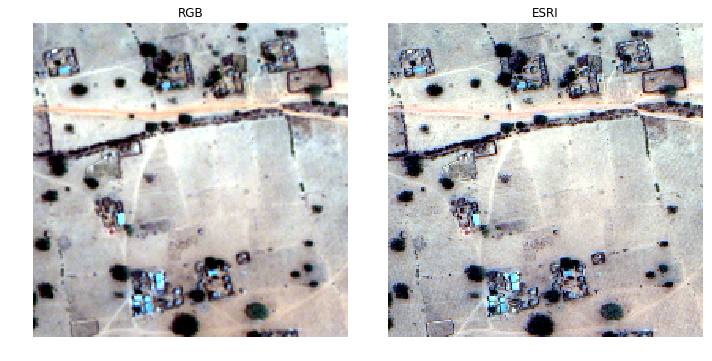

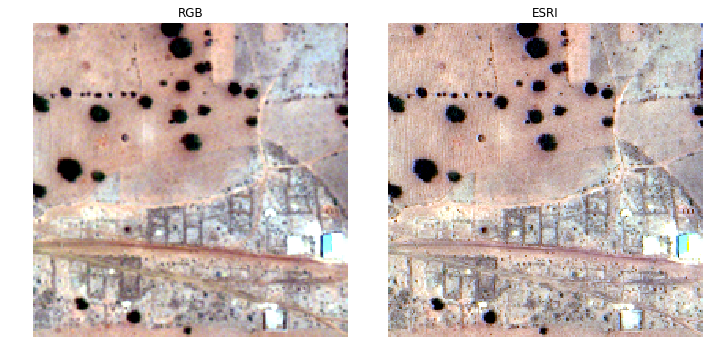

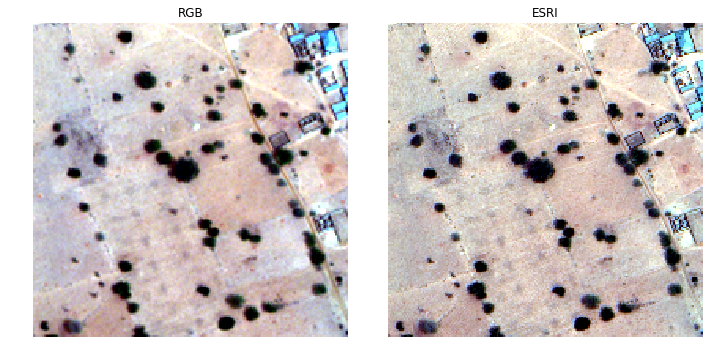

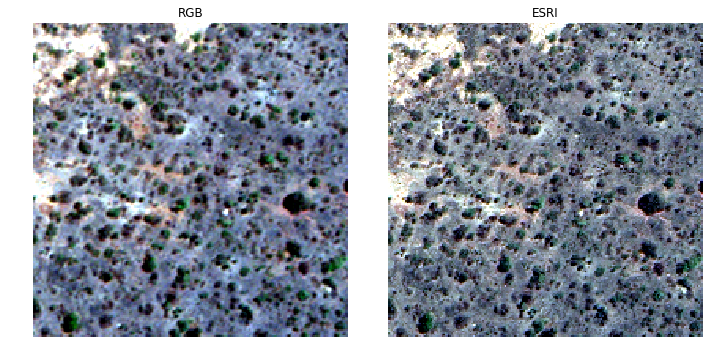

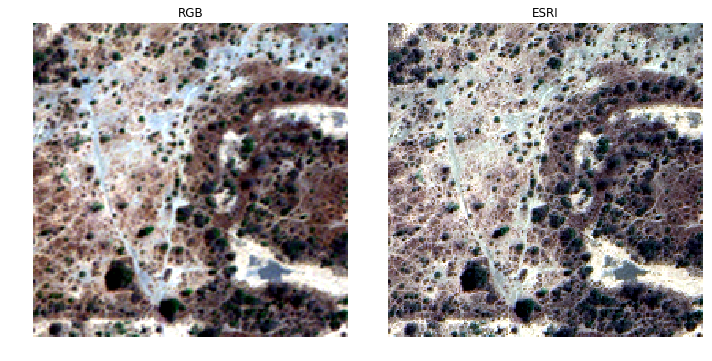

In [4]:
train = data.ImageId.unique()
test = pd.read_csv('../input/sample_submission.csv').ImageId.unique()

for IM_ID in test[:5]:
    
    # open m and p images
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    m = np.rollaxis(m, 0, 3)
    pan = tiff.imread('../input/sixteen_band/{}_P.tif'.format(IM_ID))
    
    img_orig = np.concatenate([m[:,:,4][:,:, np.newaxis],
                           m[:,:,2][:,:, np.newaxis],
                           m[:,:,1][:,:, np.newaxis]], axis=2)
    
    # pansharpen m with data in p
    m_sharp = pan_esri(m, pan)
    
    tiff.imsave('M/test/{}.tif'.format(IM_ID), m_sharp)

    img_sharp = np.concatenate([m_sharp[:,:,4][:,:, np.newaxis],
                               m_sharp[:,:,2][:,:, np.newaxis],
                               m_sharp[:,:,1][:,:, np.newaxis]], axis=2)

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()

    # no IR sharpening
    ax[0].imshow(stretch(img_orig[500:700,500:700,:]))
    ax[0].set_title('RGB')
    ax[0].axis('off')
    ax[1].imshow(stretch(img_sharp[500:700,500:700,:]))
    ax[1].set_title('ESRI')    
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()